## Butterfly Classification

### Setting up notebook and data

In [1]:
# Libraries 
import tensorflow as tf
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils.vis_utils import plot_model
from keras.layers import Input, BatchNormalization, Activation, Add, ZeroPadding2D
from keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
import tf_utils

In [2]:
# Parameters
EPOCHS = 50
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
SEED = 123

In [3]:
# Dataset preparation

# Loading
ds_dir = 'kaggle dataset'
ds = tf.keras.utils.image_dataset_from_directory(
    ds_dir,
    validation_split=0,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = ds.class_names
no_classes = len(class_names)

# Splitting
train_ds, valid_ds, test_ds = tf_utils.get_dataset_partitions(ds, 0.7, 0.15, 0.15, seed=SEED)
print(f'Batches ({BATCH_SIZE} images per batch) in subsets:')
print(f'Train: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

# Normalization
train_ds = train_ds.map(tf_utils.normalize)
valid_ds = valid_ds.map(tf_utils.normalize)
test_ds = test_ds.map(tf_utils.normalize)

Found 10033 files belonging to 75 classes.
Batches (64 images per batch) in subsets:
Train: 109
Validation: 23
Test: 25


### GoogLeNet Model

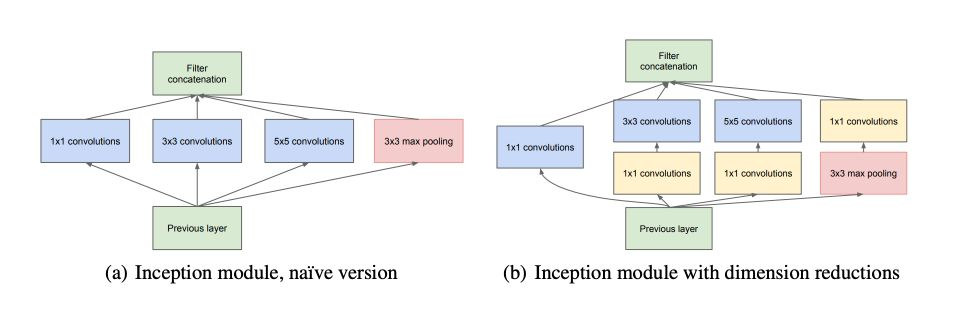

Architecture of Incepction module
[https://doi.org/10.48550/arXiv.1409.4842]

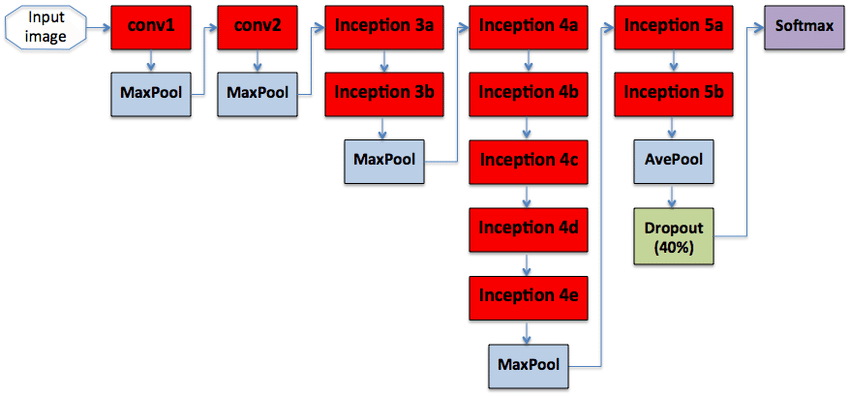

Architecture of GoogLeNet network (diagram)
[http://dx.doi.org/10.5220/0006196204790486]

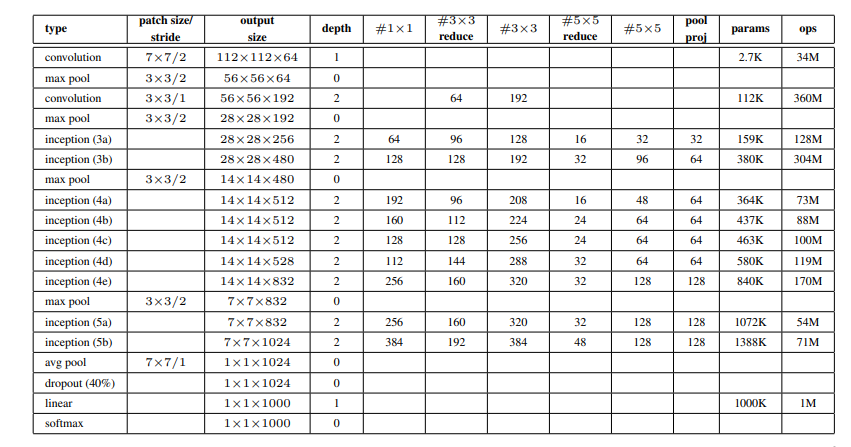

Architecture of GoogLeNet network (parameters)
[https://www.geeksforgeeks.org/understanding-googlenet-model-cnn-architecture/]

In [4]:
# Building network
def GoogLeNet_model(input_shape):
    ## Input Layer
    input_image = Input(shape=input_shape)

    ## Inception module
    def inception_module(input_layer, conv_filters, reduce_filters, pool_proj):
        layer0 = Conv2D(conv_filters[0], (1,1), padding='same', activation='relu')(input_layer)

        layer1 = Conv2D(reduce_filters[0], (1,1), padding='same', activation='relu')(input_layer)
        layer1 = Conv2D(conv_filters[1], (3,3), padding='same', activation='relu')(layer1)

        layer2 = Conv2D(reduce_filters[1], (1,1), padding='same', activation='relu')(input_layer)
        layer2 = Conv2D(conv_filters[2], (5,5), padding='same', activation='relu')(layer2)

        layer3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
        layer3 = Conv2D(pool_proj, (1,1), padding='same', activation='relu')(layer3)

        return tf.keras.layers.concatenate([layer0, layer1, layer2, layer3])

    ## Whole architecture:
    layers = Conv2D(64, (7, 7), 2, padding='same', activation='relu')(input_image)
    layers = MaxPooling2D(3, 2, padding='same')(layers)
    layers = Conv2D(192, 3, padding='same', activation='relu')(layers)
    layers = MaxPooling2D(3, 2, padding='same')(layers)
    layers = inception_module(layers, (64, 128, 32), (96, 16), 32)
    layers = inception_module(layers, (128, 192, 96), (128, 32), 64)
    layers = MaxPooling2D(3, 2, padding='same')(layers)
    layers = inception_module(layers, (192, 208, 48), (96, 16), 64)
    layers = inception_module(layers, (160, 224, 64), (112, 24), 64)
    layers = inception_module(layers, (128, 256, 64), (128, 24), 64)
    layers = inception_module(layers, (112, 288, 64), (144, 32), 64)
    layers = inception_module(layers, (256, 320, 128), (160, 32), 128)
    layers = MaxPooling2D(3, 2, padding='same')(layers)
    layers = inception_module(layers, (256, 320, 128), (160, 32), 128)
    layers = inception_module(layers, (384, 384, 128), (192, 48), 128)
    layers = AveragePooling2D(7, 7, padding='same')(layers)
    layers = Dropout(0.4)(layers)
    layers = Flatten()(layers)
    layers = Dense(1000, activation='relu')(layers)
    layers = Dense(no_classes, activation=tf.nn.softmax)(layers)

    model = Model([input_image], layers, name='GoogLeNet')
    return model

GoogLeNet = GoogLeNet_model((*IMG_SIZE, 3))
GoogLeNet.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

GoogLeNet.summary()
plot_model(GoogLeNet, to_file='diagrams/GoogLeNet.png', show_shapes=True, show_layer_names=True)

INFO:tensorflow:Assets written to: models/untrained/googlenet\assets


INFO:tensorflow:Assets written to: models/untrained/googlenet\assets


Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                          

### VGG Models

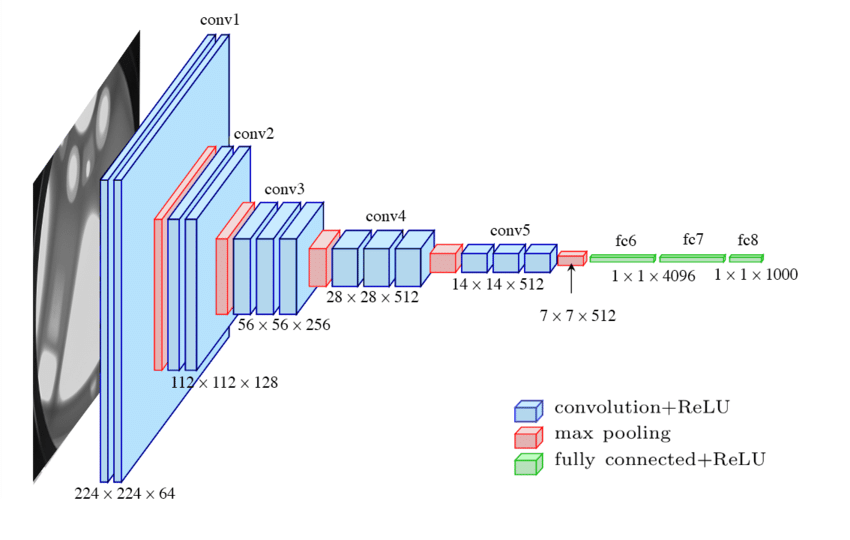

Architecture of VGG-16 model (diagram)
[http://dx.doi.org/10.1109/BigData.2017.8258115]

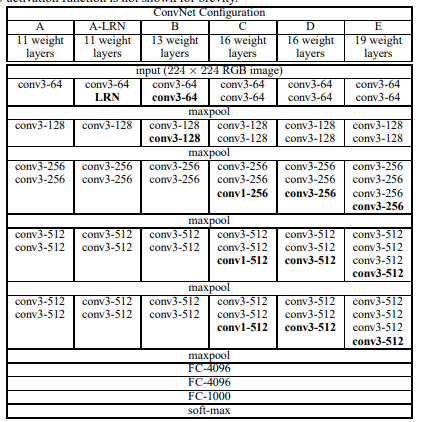

Architecture of VGG models (Column D - VGG-16, Column E - VGG-19) (table)
[https://arxiv.org/pdf/1409.1556.pdf]

Convolution layers 3x3 with stride 1. Pooling layers 2x2 with stride 2.

#### VGG-16

In [26]:
def VGG16_model(input_shape):
    # Input layer
    input_image = Input(input_shape)

    # Output layers
    layers = Conv2D(64, (3,3), (1,1), padding='same', activation='relu')(input_image)
    layers = Conv2D(64, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = MaxPooling2D((2,2), (2,2))(layers)
    layers = Conv2D(128, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(128, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = MaxPooling2D((2,2), (2,2))(layers)
    layers = Conv2D(256, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(256, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(256, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = MaxPooling2D((2,2), (2,2))(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = MaxPooling2D((2,2), (2,2))(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = MaxPooling2D((2,2), (2,2))(layers)
    layers = Dense(4096, activation='relu')(layers)
    layers = Dense(4096, activation='relu')(layers)
    layers = Dense(1000, activation='relu')(layers)
    layers = Dense(no_classes, activation='relu')(layers)

    # Model
    model = Model([input_image], layers, name='VGG-16')
    return model

Vgg_16 = VGG16_model((*IMG_SIZE, 3))
Vgg_16.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Vgg_16.summary()
plot_model(Vgg_16, to_file='diagrams/vgg_16.png', show_shapes=True, show_layer_names=True)

INFO:tensorflow:Assets written to: models/untrained/vgg-16\assets


INFO:tensorflow:Assets written to: models/untrained/vgg-16\assets


Model: "VGG-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_275 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 conv2d_276 (Conv2D)         (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_277 (Conv2D)         (None, 112, 112, 128)     73856     
                                                                 
 conv2d_278 (Conv2D)         (None, 112, 112, 128)     147584    
                                                            

#### VGG-19

In [27]:
def VGG19_model(input_shape):
    # Input layer
    input_image = Input(input_shape)

    # Output layers
    layers = Conv2D(64, (3,3), (1,1), padding='same', activation='relu')(input_image)
    layers = Conv2D(64, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = MaxPooling2D((2,2), (2,2))(layers)
    layers = Conv2D(128, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(128, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = MaxPooling2D((2,2), (2,2))(layers)
    layers = Conv2D(256, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(256, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(256, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(256, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = MaxPooling2D((2,2), (2,2))(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = MaxPooling2D((2,2), (2,2))(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = Conv2D(512, (3,3), (1,1), padding='same', activation='relu')(layers)
    layers = MaxPooling2D((2,2), (2,2))(layers)
    layers = Dense(4096, activation='relu')(layers)
    layers = Dense(4096, activation='relu')(layers)
    layers = Dense(1000, activation='relu')(layers)
    layers = Dense(no_classes, activation='relu')(layers)

    # Model
    model = Model([input_image], layers, name='VGG-19')
    return model


Vgg_19 = VGG19_model((*IMG_SIZE, 3))

Vgg_19.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Vgg_19.summary()
plot_model(Vgg_19, to_file='diagrams/vgg_19.png', show_shapes=True, show_layer_names=True)

INFO:tensorflow:Assets written to: models/untrained/vgg-19\assets


INFO:tensorflow:Assets written to: models/untrained/vgg-19\assets


Model: "VGG-19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_288 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 conv2d_289 (Conv2D)         (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_290 (Conv2D)         (None, 112, 112, 128)     73856     
                                                                 
 conv2d_291 (Conv2D)         (None, 112, 112, 128)     147584    
                                                            

### ResNet Models

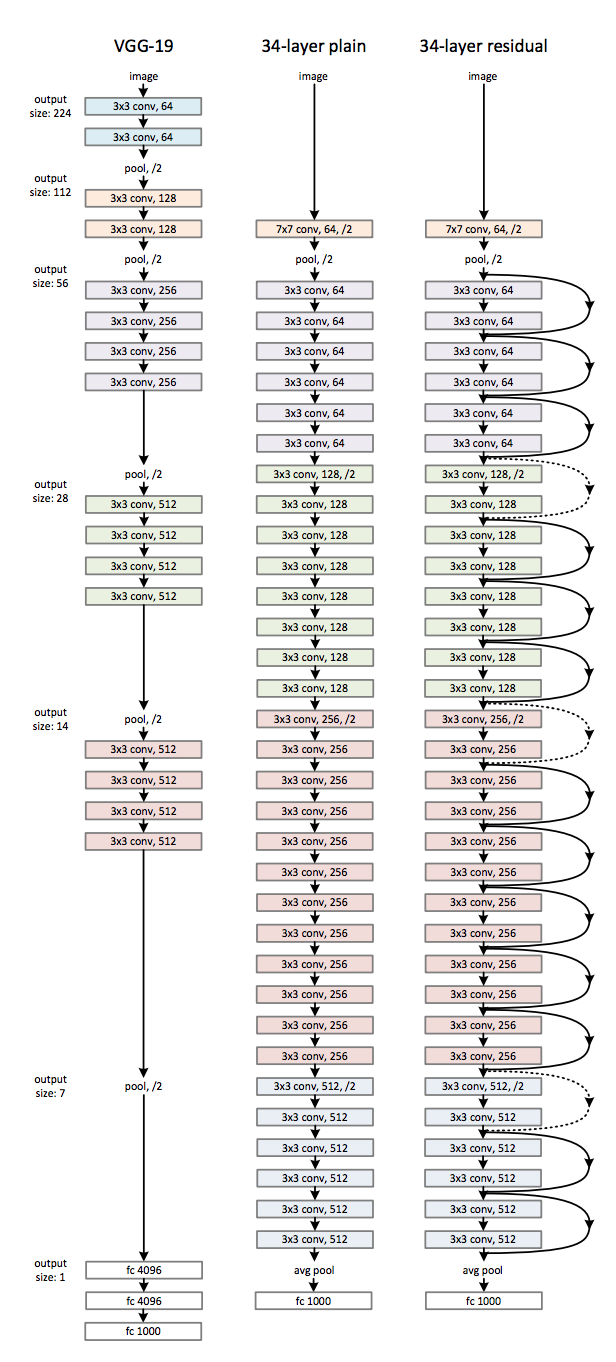

Architecture diagram of ResNet34 model (right) in compariston with VGG (left)
[https://arxiv.org/abs/1512.03385]

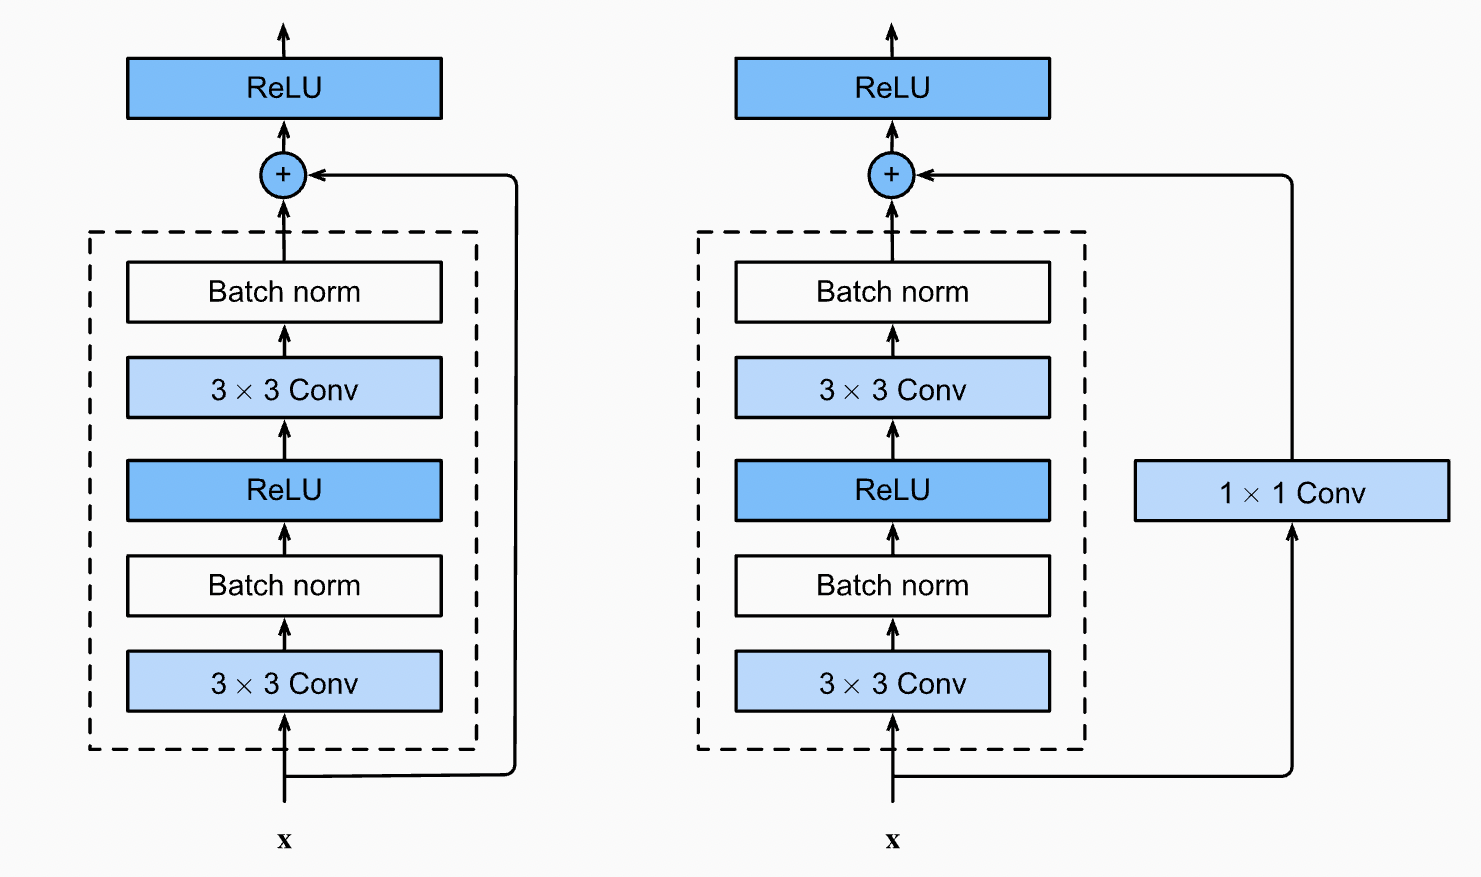

Identity (left) and convolutional (right) block of ResNet model
[https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/]

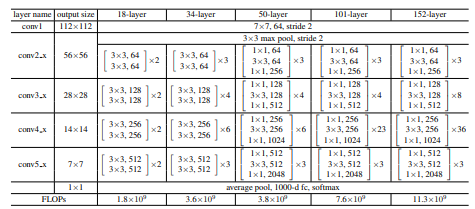

ResNet architecture for different layers
[https://arxiv.org/abs/1512.03385]

In [29]:
# Identity module:
def identity_module(input_layer, filter):
    layer1 = Conv2D(filter, (3, 3), (1, 1), padding='same')(input_layer)
    layer1 = BatchNormalization(axis=3)(layer1)
    layer1 = Activation('relu')(layer1)

    layer2 = Conv2D(filter, (3, 3), (1, 1), padding='same')(layer1)
    layer2 = BatchNormalization(axis=3)(layer2)

    # Adding residue
    output = Add()([input_layer, layer2])
    output = Activation('relu')(output)

    return output

# Convolutional module
def convolutional_module(input_layer, filter):
    layer1 = Conv2D(filter, (3, 3), (2, 2), padding='same')(input_layer)
    layer1 = BatchNormalization(axis=3)(layer1)
    layer1 = Activation('relu')(layer1)
    
    layer2 = Conv2D(filter, (3, 3), (1, 1), padding='same')(layer1)
    layer2 = BatchNormalization(axis=3)(layer2)

    skip_layer = Conv2D(filter, (1, 1), (2, 2))(input_layer)

    # Adding residue
    output = Add()([layer2, skip_layer])
    output = Activation('relu')(output)

    return output

### ResNet18

In [ ]:
def ResNet18_model(input_shape):
    # Input layer
    input_image = Input((*IMG_SIZE, 3))
    input_image = ZeroPadding2D((3, 3))(input_image)

    # Initial layers
    init_layer = Conv2D(64, (7, 7), (2, 2), padding='same')(input_image)
    init_layer = BatchNormalization()(init_layer)
    init_layer = Activation('relu')(init_layer)
    init_layer = MaxPooling2D((3, 3), (2, 2), padding='same')(init_layer)

    # Residual layers
    block1 = identity_module(init_layer, 64)
    block1 = identity_module(block1, 64)

    block2 = convolutional_module(block1, 128)
    block2 = identity_module(block2, 128)

    block3 = convolutional_module(block2, 256)
    block3 = identity_module(block3, 256)

    block4 = convolutional_module(block3, 512)
    block4 = identity_module(block4, 512)

    # Output dense layers
    output = AveragePooling2D((2, 2), padding='same')(block4)
    output = Flatten()(output)
    output = Dense(512, activation='relu')(output)
    output = Dense(no_classes, activation=tf.nn.softmax)(output)

    # Model
    model = Model([input_image], output, name='ResNet34')
    return model


ResNet18 = ResNet18_model((*IMG_SIZE, 3))

ResNet18.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

ResNet18.summary()
plot_model(ResNet18, to_file='diagrams/resnet34.png', show_shapes=True, show_layer_names=True)

#### ResNet34

In [22]:
def ResNet34_model(input_shape):
    # Input layer
    input_image = Input((*IMG_SIZE, 3))
    input_image = ZeroPadding2D((3, 3))(input_image)

    # Initial layers
    init_layer = Conv2D(64, (7, 7), (2, 2), padding='same')(input_image)
    init_layer = BatchNormalization()(init_layer)
    init_layer = Activation('relu')(init_layer)
    init_layer = MaxPooling2D((3, 3), (2, 2), padding='same')(init_layer)

    # Residual layers
    block1 = identity_module(init_layer, 64)
    block1 = identity_module(block1, 64)
    block1 = identity_module(block1, 64)
    block1 = identity_module(block1, 64)

    block2 = convolutional_module(block1, 128)
    block2 = identity_module(block2, 128)
    block2 = identity_module(block2, 128)
    block2 = identity_module(block2, 128)

    block3 = convolutional_module(block2, 256)
    block3 = identity_module(block3, 256)
    block3 = identity_module(block3, 256)
    block3 = identity_module(block3, 256)
    block3 = identity_module(block3, 256)
    block3 = identity_module(block3, 256)

    block4 = convolutional_module(block3, 512)
    block4 = identity_module(block4, 512)
    block4 = identity_module(block4, 512)
    block4 = identity_module(block4, 512)

    # Output dense layers
    output = AveragePooling2D((2, 2), padding='same')(block4)
    output = Flatten()(output)
    output = Dense(512, activation='relu')(output)
    output = Dense(no_classes, activation=tf.nn.softmax)(output)

    # Model
    model = Model([input_image], output, name='ResNet34')
    return model


ResNet34 = ResNet34_model((*IMG_SIZE, 3))

ResNet34.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

ResNet34.summary()
plot_model(ResNet34, to_file='diagrams/resnet34.png', show_shapes=True, show_layer_names=True)

INFO:tensorflow:Assets written to: models/untrained/resnet34\assets


INFO:tensorflow:Assets written to: models/untrained/resnet34\assets


Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 230, 230, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_179 (Conv2D)            (None, 115, 115, 64  9472        ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_12 (BatchN  (None, 115, 115, 64  256        ['conv2d_179[1][0]']             
 ormalization)                  )                                                          